# AD integration

## 0. Imports

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)

In [2]:
from agd import HFMUtils
from agd import Metrics
from agd import AutomaticDifferentiation as ad

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def reload_packages():
    from importlib import reload
    HFMUtils = reload(sys.modules['agd.HFMUtils'])
    HFMUtils.reload_submodules()
    ad.reload_submodules()

In [5]:
reload_packages()

## 1. Basic problem

In [6]:
hfmIn = HFMUtils.dictIn({})
hfmIn['model']='Isotropic2' # Alternatively 'IsotropicDiff2'

In [7]:
hfmIn['arrayOrdering']='RowMajor'
# Define the domain
hfmIn.SetRect(sides=[[-1,1],[0,1]],gridScale=1./100.)
#hfmIn.update(
#    HFMUtils.Rect(sides=[[-1,1],[0,1]],gridScale=1./100.)
#)


# Set up the boundary conditions
hfmIn['seeds']=[[-0.5,0.3],[0.5,0.8]] # Seed position
hfmIn['seedValues']=[0.,0.5] # Boundary condition imposed at the seed. Defaults to $[0.,0.]$.

# Define the speed function
X,Y = HFMUtils.GetGrid(hfmIn) # Create a coordinate system

hfmIn['cost'] = np.exp(-0.5*(X**2+Y**2)) # Define the cost function


# Insert the obstacles
disk = (X-0.3)**2 + (Y-0.3)**2 <= 0.2**2
barrier = np.logical_and(X==X[0,70], Y>=0.4)
hfmIn['walls']= np.logical_or(disk,barrier) 

# Request the desired outputs
hfmIn['exportValues']=1. # Ask for the PDE solution
hfmIn['tips'] = [[0.,0.6],[-0.9,0.5],[0.8,0.8]] # Ask for the geodesics from these three points

In [8]:
hfmIn['cost'] = Metrics.Isotropic(np.exp(-0.5*(X**2+Y**2))) # Define the cost function

In [9]:
hfmOut=hfmIn.Run(smart=True)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004946 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


In [10]:
hfmIn.PointFromIndex([[0,0],[1,1]])

array([[-0.995,  0.005],
       [-0.985,  0.015]])

In [11]:
seedCI = hfmIn.PointFromIndex(hfmIn['seeds'],to=True)
hfmIn.IndexFromPoint(hfmIn['seeds'])

(array([[ 50,  29],
        [150,  80]]), array([[-0.5,  0.5],
        [-0.5, -0.5]]))

## Forward AD

In [12]:
reload_packages()

In [13]:
dx = ad.Dense.identity((3,))

In [14]:
cost_ad = np.exp(-0.5*(X**2+Y**2)) *(1. + dx[0]*(X>0) + dx[1]*(X<=0) )
hfmIn['seedValues'] = ad.array((0,dx[2]))
hfmIn['cost'] = cost_ad; #Metrics.Isotropic(cost_ad) # Equivalent

In [15]:
#cost= hfmIn['cost'] #.to_HFM()
#hfmIn['costVariation']= np.stack([(X>0.)*cost, (X<=0.)*cost, 0.*X],2) 
#hfmIn['seedValueVariation']=np.stack([[0,0],[0,0],hfmIn['seedValues']],1).T

In [16]:
hfmOut = HFMUtils.Run(hfmIn,smart=True)

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.005528 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


In [17]:
hfmOut.keys()

dict_keys(['FMCPUTime', 'GeodesicCPUTime', 'MaxStencilWidth', 'StencilCPUTime', 'defaulted', 'geodesics', 'nAccepted', 'unusedFromCompute', 'values', 'visitedUnset', 'retcode'])

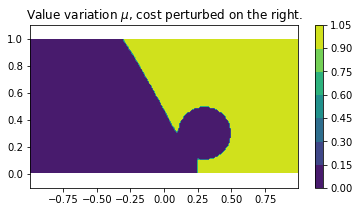

In [18]:
plt.figure(figsize=[6,3]); plt.title(f'Value variation $\mu$, cost perturbed on the right.'); plt.axis('equal'); 
# The field 'valueVariation' is denoted mu in the above mathematical expression.
plt.contourf(X,Y,hfmOut['values'].gradient()[2]) 
plt.axis('equal');plt.colorbar();

## Some tests on reverse AD

In [19]:
def my_operator(u,v,co_output=None):    
    # Generate an operator-like AD environnement
    rev,(u1,v1) = ad.Reverse.operator_like(inputs=(u,v),co_output=co_output)
    
    # Do some computations
#    u2 = rev.apply_linear_mapping(transport_matrix,u1**2,niter=nsteps)
    result = u1*v1
    
    # Return the suitably converted result
    return rev.output(result)

In [22]:
reload_packages()

In [25]:
#x0=np.linspace(0,np.pi,4)
#gridScale=x0[1]-x0[0]
#u0=np.sin(x0)
#v0=np.cos(x0)

u0 = np.array(1.); v0= np.array(2.) 
#u0 = np.array([1.]); v0= np.array([2.]) 
#u0=np.array([1.,2,3]); v0=np.array([4.,5,6])
#u0 = np.array([[1.,2.],[3.,4.]]); v0= np.array([[2.,3.],[4.,5.]]) 


rev,(u1,v1) = ad.Reverse.empty(inputs=(u0,v0))

result_Reverse = (rev.apply(my_operator,u1,u1*v1)*v1).sum()

grad = rev.gradient(result_Reverse)

In [26]:
grad

array([8., 4.])

In [24]:
def myfun(a,b,co_output=None):
    rev,(a1,b1) = ad.Reverse.operator_like(inputs=(a,b),co_output=co_output)
    result = a1+b1
    return rev.output(result)

In [134]:
reload_packages()

In [135]:
x=np.array([1.,2.]); y=np.array([2.,3.])
rev,(x_ad,y_ad) = ad.Reverse.empty(inputs=(x,y))

#rev.input_iterables.add(tuple)
xy = rev.apply(myfun,x_ad,y_ad)

In [136]:
rev.gradient(xy)

ValueError: cannot reshape array of size 0 into shape (2,)

In [103]:
import numbers
isinstance(np.float64(2.),numbers.Real)

True

In [80]:
rev.apply(myfun,x,(y,None))

3.0

In [111]:
np.prod(tuple(),dtype=int)

1

In [104]:
isinstance(np.array(2.),numbers.Real)

False

In [75]:
ad.reload_submodules()

In [76]:
ad.Sparse.identity(constant=1.)

spAD(array(1.), array([1.]), array([0]))

In [74]:
int(np.prod(tuple(())))

1

## Reverse AD

In [31]:
reload_packages()

In [32]:
hfmIn = HFMUtils.dictIn({})
hfmIn['model']='Isotropic2' # Alternatively 'IsotropicDiff2'

hfmIn['arrayOrdering']='RowMajor'
# Define the domain
hfmIn.SetRect(sides=[[-1,1],[0,1]],gridScale=1./100.)

# Set up the boundary conditions
hfmIn['seeds']=[[-0.5,0.3],[0.5,0.8]] # Seed position
hfmIn['seedValues']=[0.,0.5] # Boundary condition imposed at the seed. Defaults to $[0.,0.]$.

# Define the speed function
X,Y = HFMUtils.GetGrid(hfmIn) # Create a coordinate system

#hfmIn['cost'] = np.exp(-0.5*(X**2+Y**2)) # Define the cost function


# Insert the obstacles
disk = (X-0.3)**2 + (Y-0.3)**2 <= 0.2**2
barrier = np.logical_and(X==X[0,70], Y>=0.4)
hfmIn['walls']= np.logical_or(disk,barrier) 

# Request the desired outputs
hfmIn['exportValues']=1. # Ask for the PDE solution
hfmIn['tips'] = [[0.,0.6],[-0.9,0.5],[0.8,0.8]] # Ask for the geodesics from these three points

In [33]:
cost = np.exp(-0.5*(X**2+Y**2))
rev,(cost_ad,) = ad.Reverse.empty(inputs=(cost,))

In [34]:
hfmOut,(values,) = hfmIn.RunSmart(tupleIn=(('cost',cost),),tupleOut=('values',))

Field verbosity defaults to 1
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.004832 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Field exportActiveNeighs defaults to 0
Field exportGeodesicFlow defaults to 0


In [35]:
values

array([[0.43696365, 0.43283144, 0.42877587, ...,        inf,        inf,
               inf],
       [0.43248251, 0.42828163, 0.42415812, ..., 0.5207593 , 0.52405863,
        0.52734366],
       [0.42798235, 0.4237113 , 0.41951831, ..., 0.51884256, 0.5221936 ,
        0.52552959],
       ...,
       [1.11687936, 1.11067271, 1.10447049, ..., 0.75909851, 0.76001102,
        0.76098528],
       [1.11724177, 1.11109624, 1.10495524, ..., 0.76284204, 0.76370212,
        0.76462314],
       [1.11760969, 1.11152525, 1.10544542, ..., 0.76655744, 0.7673665 ,
        0.76823571]])

In [42]:
myset = {1,2,3}
myset.add(4)
myset

{1, 2, 3, 4}

In [44]:
set([1,2,3])

{1, 2, 3}

In [48]:
dict({1:1})

{1: 1}

In [51]:
reload_packages()

In [26]:
rev.input_iterables
hfmOut,(values,) = rev.apply(HFMUtils.RunSmart,hfmIn,tupleIn=(('cost',cost_ad),),tupleOut=('values',))

ValueError: Invalid type for key cost

In [45]:
for x in range(10) if x!=3:
    print(x)

SyntaxError: invalid syntax (<ipython-input-45-999e2f7103fa>, line 1)

In [46]:
[x for x in range(10) if x!=3]

[0, 1, 2, 4, 5, 6, 7, 8, 9]

In [138]:
type(values),type(cost_ad)

(numpy.ndarray, agd.AutomaticDifferentiation.Sparse.spAD)

In [123]:
rev.gradient(values[0,0])

AttributeError: 'denseAD' object has no attribute 'index'

In [122]:
values[0,0]

denseAD(array(0.43696365),array([0.59703622]))

In [86]:
a,(b,) = 0,tup
b

1

## Old

In [ ]:
from agd import HFMUtils

In [9]:
from agd import AutomaticDifferentiation as ad
import numpy as np

In [3]:
ad.array(((1,0),(0,1)))

array([[1, 0],
       [0, 1]])

In [7]:
u = ad.Dense.identity((2,))

In [10]:
ad.array((u,np.zeros((2,))))

denseAD(array([[0., 0.],
       [0., 0.]]),
array([[[1., 0.],
        [0., 1.]],

       [[0., 0.],
        [0., 0.]]]))

In [12]:
5 not in [2,3,4]

True

In [15]:
dico = {"a":2}
dico.get("b",3)

3

In [19]:
if 0.: print(True)

In [20]:
"abc" is "abc"

True

In [21]:
2. is 2.

True

In [22]:
2. is 2

False

In [23]:
"ab_"+str(2)

'ab_2'

In [63]:
"values" is 'values'

True